# Particle Identification Notebook

We tackle the particle identification of neutrons and gamma-rays using LaBr3 detectors (gamma rays) and CLYC detecotrs (neutrons). It is critical to correctly identify the particles in order to perform the coincidence analysis. 

## Imports

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from DataFormat  import DataFormat
from read_data   import read_data
from calibration import read_calibration_parameters, linear_calibration

from sklearn.cluster import DBSCAN, OPTICS, KMeans, MiniBatchKMeans
from matplotlib.colors import LogNorm

from sklearn.preprocessing import StandardScaler

import seaborn as sns
import tensorflow as tf

## Constants

In [2]:
DATA_PATH   = "./data"
DATA_PREFIX = "beam-analysis-day"

LABR_A  = "labr-a"
LABR_B  = "labr-b"
CLYC    = "clyc"
PLASTIC = "plastic"

## Read data

In [3]:
run_day  = 2

data_labr_a = read_data(DATA_PATH, f"{DATA_PREFIX}{run_day}.root", DataFormat(LABR_A))
data_labr_b = read_data(DATA_PATH, f"{DATA_PREFIX}{run_day}.root", DataFormat(LABR_A))
data_clyc   = read_data(DATA_PATH, f"{DATA_PREFIX}{run_day}.root", DataFormat(CLYC))

In [4]:
# clean data from saturated events
data_labr_a = data_labr_a[data_labr_a["energy"] < data_labr_a["energy"].max()]
data_labr_b = data_labr_b[data_labr_b["energy"] < data_labr_b["energy"].max()]
data_clyc   = data_clyc[data_clyc["energy"] < data_clyc["energy"].max()]

# clean data from zero energy events
data_labr_a = data_labr_a[data_labr_a["energy"] > 0]
data_labr_b = data_labr_b[data_labr_b["energy"] > 0]
data_clyc   = data_clyc[data_clyc["energy"] > 0]

## Calibration

In [5]:
param_labr_a = read_calibration_parameters(
    "./calibration-parameters/labr_a_linear_parameters.txt"
)

param_labr_b = read_calibration_parameters(
    "./calibration-parameters/labr_b_linear_parameters.txt"
)

param_clyc = read_calibration_parameters(
    "./calibration-parameters/clyc_linear_parameters.txt"
)

In [6]:
data_labr_a.loc[:, "energy_calib"]       = linear_calibration(data_labr_a["energy"], param_labr_a)
data_labr_a.loc[:, "energy_short_calib"] = linear_calibration(data_labr_a["energy_short"], param_labr_a)

data_labr_b.loc[:, "energy_calib"]       = linear_calibration(data_labr_b["energy"], param_labr_b)
data_labr_b.loc[:, "energy_short_calib"] = linear_calibration(data_labr_b["energy_short"], param_labr_b)

data_clyc.loc[:,   "energy_calib"]       = linear_calibration(data_clyc["energy"], param_clyc)
data_clyc.loc[:,   "energy_short_calib"] = linear_calibration(data_clyc["energy_short"], param_clyc)

In [7]:
def compute_psd(df):
    return (df["energy"] - df["energy_short"]) / df["energy"]

def compute_psd_calib(df):
    return (df["energy_calib"] - df["energy_short_calib"]) / df["energy_calib"]

data_labr_a.loc[:, "psd"] = compute_psd(data_labr_a)
data_labr_b.loc[:, "psd"] = compute_psd(data_labr_b)
data_clyc.loc[:,   "psd"] = compute_psd(data_clyc)
data_labr_a.loc[:, "psd_calib"] = compute_psd_calib(data_labr_a)
data_labr_b.loc[:, "psd_calib"] = compute_psd_calib(data_labr_b)
data_clyc.loc[:,   "psd_calib"] = compute_psd_calib(data_clyc)

In [8]:
# remove all points that have a psd or psd_calib value greater than 1
def remove_psd_outliers(df):
    return df[(df["psd"] < 1) & (df["psd_calib"] < 1)]

data_labr_a = remove_psd_outliers(data_labr_a)
data_labr_b = remove_psd_outliers(data_labr_b)
data_clyc   = remove_psd_outliers(data_clyc)

## Spectra and PSD

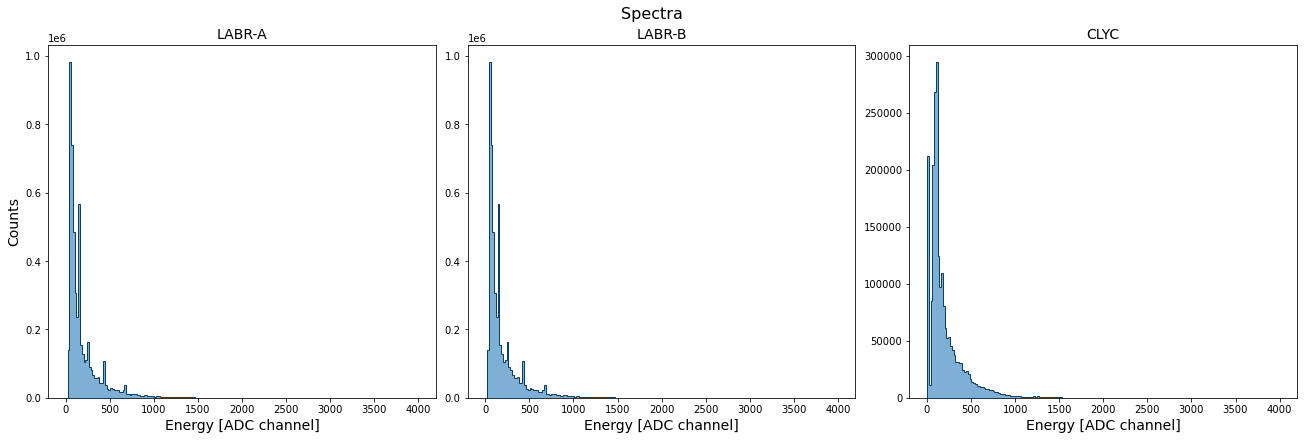

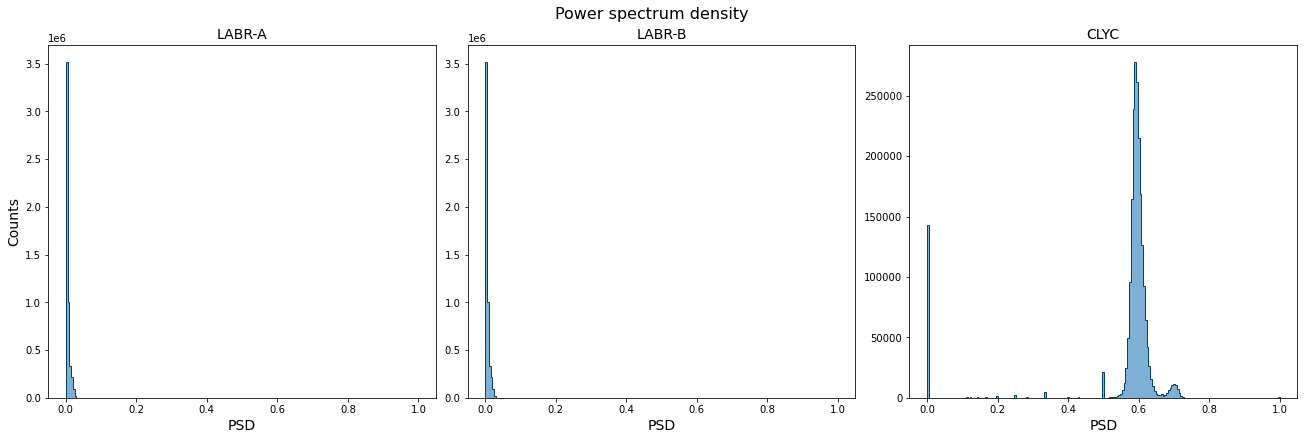

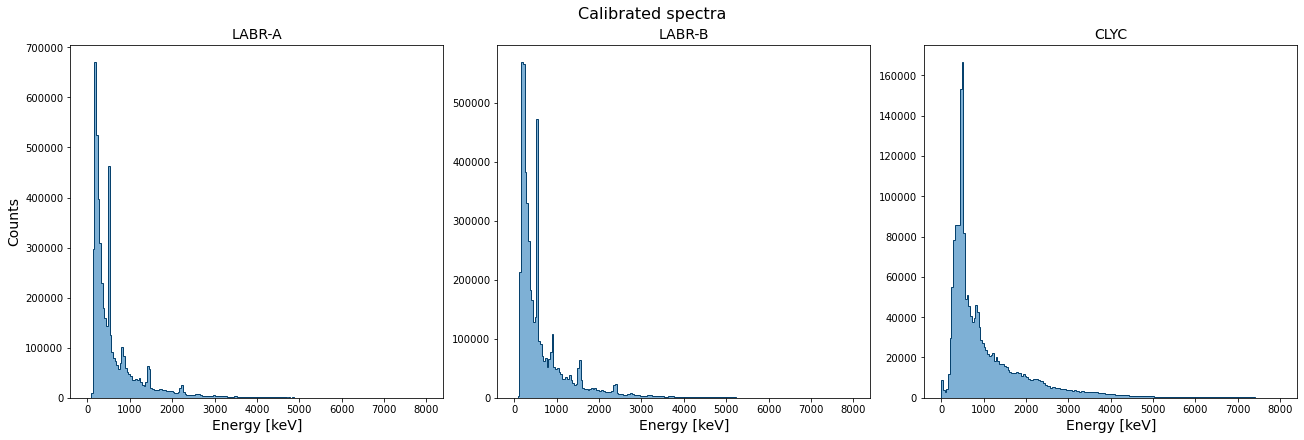

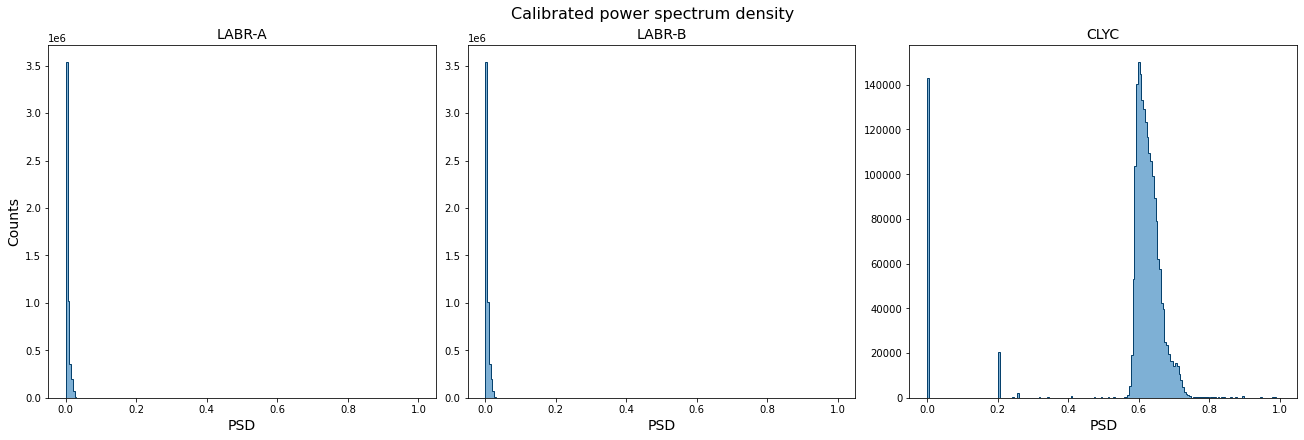

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharex=True)

bins = np.linspace(0, 4000, 200)

ax[0].hist(data_labr_a["energy"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-A")
ax[1].hist(data_labr_b["energy"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-B")
ax[2].hist(data_clyc["energy"],   bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="CLYC")

fig.suptitle("Spectra", fontsize=16)
ax[0].set_title("LABR-A", fontsize=14)
ax[0].set_ylabel("Counts", fontsize=14)
ax[0].set_xlabel("Energy [ADC channel]", fontsize=14)
ax[1].set_title("LABR-B", fontsize=14)
ax[1].set_xlabel("Energy [ADC channel]", fontsize=14)
ax[2].set_title("CLYC", fontsize=14)
ax[2].set_xlabel("Energy [ADC channel]", fontsize=14)

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharex=True)

bins = np.linspace(0, 1, 200)

ax[0].hist(data_labr_a["psd"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-A")
ax[1].hist(data_labr_b["psd"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-B")
ax[2].hist(data_clyc["psd"],   bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="CLYC")

fig.suptitle("Power spectrum density", fontsize=16)
ax[0].set_title("LABR-A", fontsize=14)
ax[0].set_ylabel("Counts", fontsize=14)
ax[0].set_xlabel("PSD", fontsize=14)
ax[1].set_title("LABR-B", fontsize=14)
ax[1].set_xlabel("PSD", fontsize=14)
ax[2].set_title("CLYC", fontsize=14)
ax[2].set_xlabel("PSD", fontsize=14)

plt.show()


fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharex=True)

bins = np.linspace(0, 8000, 200)

ax[0].hist(data_labr_a["energy_calib"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-A")
ax[1].hist(data_labr_b["energy_calib"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-B")
ax[2].hist(data_clyc["energy_calib"],   bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="CLYC")

fig.suptitle("Calibrated spectra", fontsize=16)
ax[0].set_title("LABR-A", fontsize=14)
ax[0].set_ylabel("Counts", fontsize=14)
ax[0].set_xlabel("Energy [keV]", fontsize=14)
ax[1].set_title("LABR-B", fontsize=14)
ax[1].set_xlabel("Energy [keV]", fontsize=14)
ax[2].set_title("CLYC", fontsize=14)
ax[2].set_xlabel("Energy [keV]", fontsize=14)

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharex=True)

bins = np.linspace(0, 1, 200)

ax[0].hist(data_labr_a["psd_calib"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-A")
ax[1].hist(data_labr_b["psd_calib"], bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="LABR-B")
ax[2].hist(data_clyc["psd_calib"],   bins=bins, histtype="stepfilled", edgecolor = "#06416D", facecolor = "#7eb0d5", label="CLYC")

fig.suptitle("Calibrated power spectrum density", fontsize=16)
ax[0].set_title("LABR-A", fontsize=14)
ax[0].set_ylabel("Counts", fontsize=14)
ax[0].set_xlabel("PSD", fontsize=14)
ax[1].set_title("LABR-B", fontsize=14)
ax[1].set_xlabel("PSD", fontsize=14)
ax[2].set_title("CLYC", fontsize=14)
ax[2].set_xlabel("PSD", fontsize=14)

plt.show()

## PSD vs Energy for CLYC

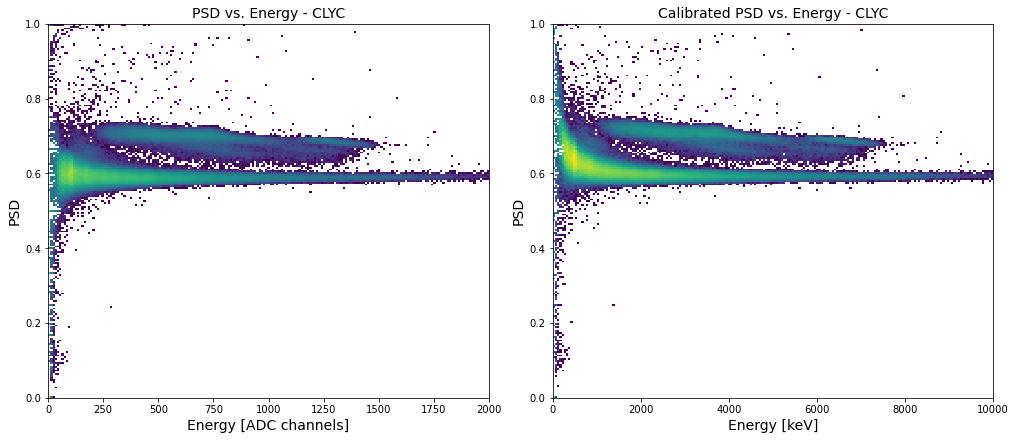

In [9]:
from matplotlib.colors import LogNorm


fig, ax = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

e_bins = np.linspace(0, 2000, 200)
psd_bins = np.linspace(0, 1, 200)

ax[0].hist2d(data_clyc["energy"], data_clyc["psd"], bins=(e_bins, psd_bins), cmap="viridis", norm=LogNorm())
ax[0].set_title("PSD vs. Energy - CLYC", fontsize=14)
ax[0].set_xlabel("Energy [ADC channels]", fontsize=14)
ax[0].set_ylabel("PSD", fontsize=14)

e_bins = np.linspace(0, 10000, 200)
psd_bins = np.linspace(0, 1, 200)

ax[1].hist2d(data_clyc["energy_calib"], data_clyc["psd_calib"], bins=(e_bins, psd_bins), cmap="viridis", norm=LogNorm())
ax[1].set_title("Calibrated PSD vs. Energy - CLYC", fontsize=14)
ax[1].set_xlabel("Energy [keV]", fontsize=14)
ax[1].set_ylabel("PSD", fontsize=14)

plt.show()

## Particle Identification

In [9]:
data = np.array([data_clyc["energy"], data_clyc["psd"]]).T
data.shape

(2163763, 2)

In [10]:
# assign an id to each point to keep track of it
data = np.hstack([data, np.arange(data.shape[0]).reshape(-1, 1)])

# create a number of subsets of the data with 50000 points each
subsets = [
    data[np.random.randint(0, data.shape[0], 50000), :] for _ in range(8)
]

In [11]:
# make a pandas dataframe out of the entire data set
df = pd.DataFrame(data, columns=["energy", "psd", "id"])

# cluster only the points that have PSD > 0.5 and PSD < 0.75 and energy < 2000
df_cluster = df[(df["psd"] > 0.5) & (df["psd"] < 0.75) & (df["energy"] < 2000)]


df_subset = df_cluster.sample(100000)

df_subset.head()

,energy,psd,id
183341,326.0,0.613497,183341.0
1971439,204.0,0.573529,1971439.0
1712094,105.0,0.619048,1712094.0
180423,195.0,0.589744,180423.0
904673,97.0,0.597938,904673.0


## Autoencoder

In [12]:
import tensorflow as tf

input_dim  = 2
latent_dim = 16
nlayers    = 5

nmax = 2**nlayers * latent_dim

# encoder
inputs = tf.keras.layers.Input(shape=(input_dim,), name="encoder_input")
encoded = tf.keras.layers.Dense(latent_dim*2**(nlayers+1), activation="relu", name="encoder_layer_1")(inputs)

for l in range(nlayers):
    encoded = tf.keras.layers.Dense(
        latent_dim * 2**(nlayers - (l)),
        activation="relu",
        name=f"encoder_layer_{l + 2}",
    )(encoded)
    encoded = tf.keras.layers.Dropout(0.2)(encoded)

# latent space
latent = tf.keras.layers.Dense(latent_dim, activation="relu", name="latent_space")(encoded)

# decoder
decoded = tf.keras.layers.Dense(latent_dim*2, activation="relu", name="decoder_layer_1")(latent)

for l in range(nlayers):
    decoded = tf.keras.layers.Dense(
        latent_dim * 2**(l+2),
        activation="relu",
        name=f"decoder_layer_{l + 2}",
    )(decoded)
    decoded = tf.keras.layers.Dropout(0.2)(decoded)

outputs = tf.keras.layers.Dense(input_dim, activation="relu", name="decoder_output")(decoded)

# autoencoder
autoencoder = tf.keras.Model(inputs, outputs, name="autoencoder")

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.keras.losses.MeanSquaredError())

autoencoder.summary()

2022-12-21 09:35:09.012812: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-21 09:35:09.013538: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 encoder_layer_1 (Dense)     (None, 1024)              3072      
                                                                 
 encoder_layer_2 (Dense)     (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 encoder_layer_3 (Dense)     (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                        

In [13]:
# Create the autoencoder model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df_subset[['energy', 'psd']])

# Fit the model to the data
autoencoder.fit(X, X, epochs=10, batch_size=50, shuffle=True, validation_split=0.2)


2022-12-21 09:35:11.791492: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-12-21 09:35:12.153510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1598/1600 [============================>.] - ETA: 0s - loss: 0.6103

2022-12-21 09:35:38.106263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1600/1600 [==============================] - 28s 17ms/step - loss: 0.6101 - val_loss: 0.5676
Epoch 2/10
1600/1600 [==============================] - 27s 17ms/step - loss: 0.4052 - val_loss: 0.2703
Epoch 3/10
1600/1600 [==============================] - 26s 17ms/step - loss: 0.2433 - val_loss: 0.2513
Epoch 4/10
1600/1600 [==============================] - 27s 17ms/step - loss: 0.2375 - val_loss: 0.2516
Epoch 5/10
1600/1600 [==============================] - 27s 17ms/step - loss: 0.2371 - val_loss: 0.2507
Epoch 6/10
1600/1600 [==============================] - 27s 17ms/step - loss: 0.2369 - val_loss: 0.2508
Epoch 7/10
1600/1600 [==============================] - 26s 16ms/step - loss: 0.2369 - val_loss: 0.2541
Epoch 8/10
1600/1600 [==============================] - 26s 16ms/step - loss: 0.2369 - val_loss: 0.2528
Epoch 9/10
1600/1600 [==============================] - 26s 16ms/step - loss: 0.2369 - val_loss: 0.2516
Epoch 10/10
1600/1600 [==============================] - 26s 16ms/step - lo

2022-12-21 09:39:39.247556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-12-21 09:39:45.641282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


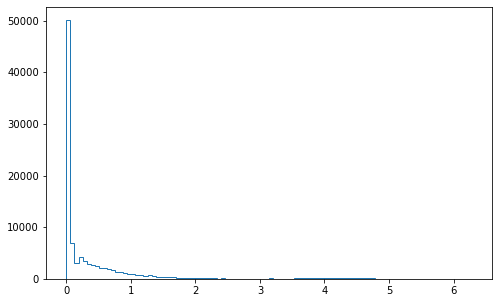

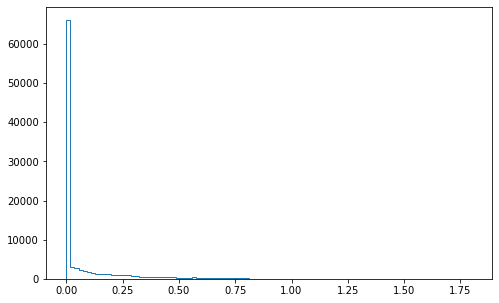

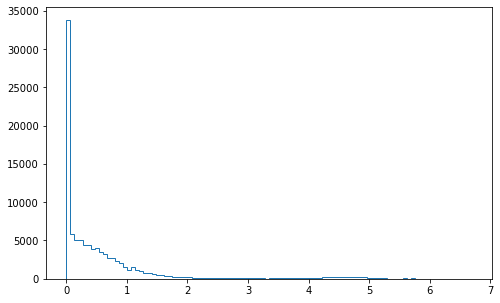

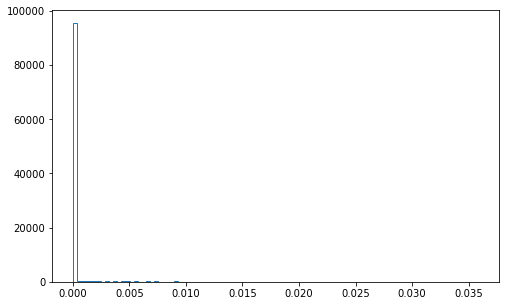

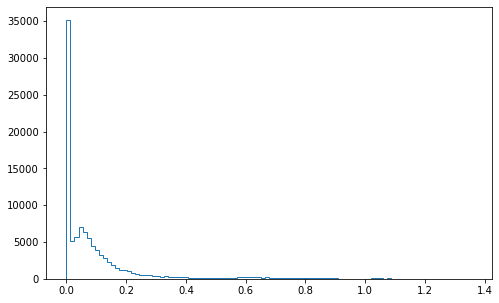

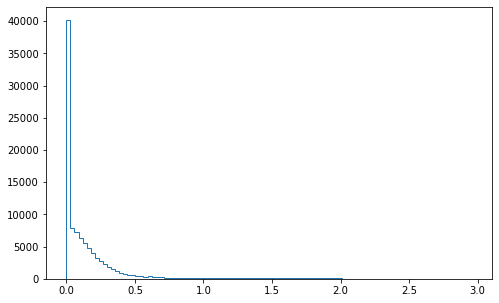

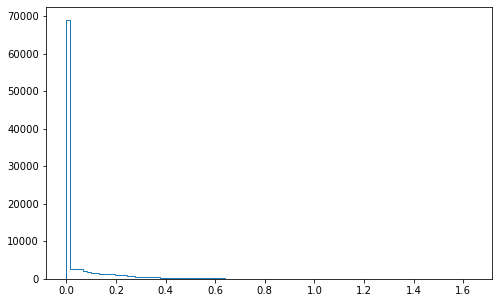

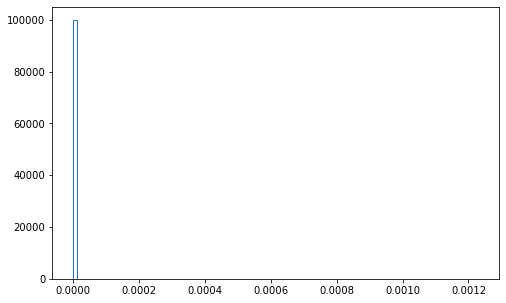

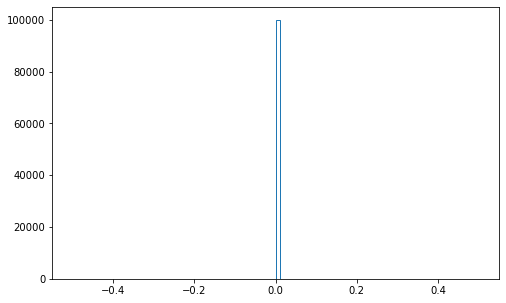

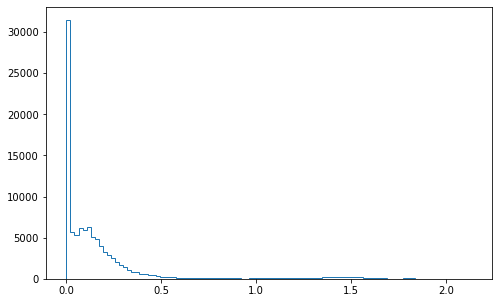

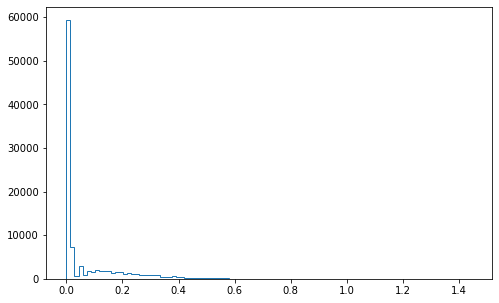

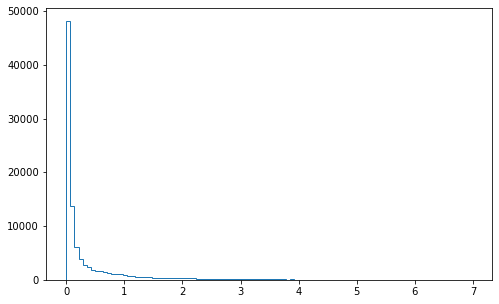

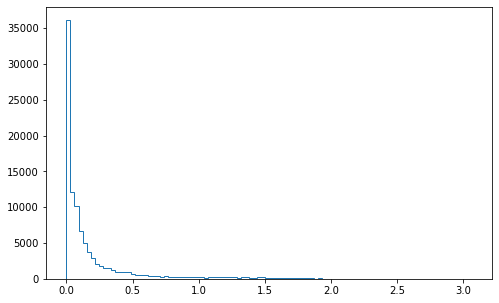

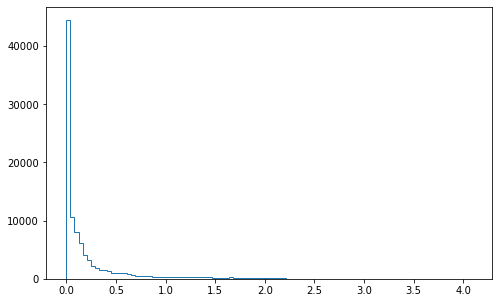

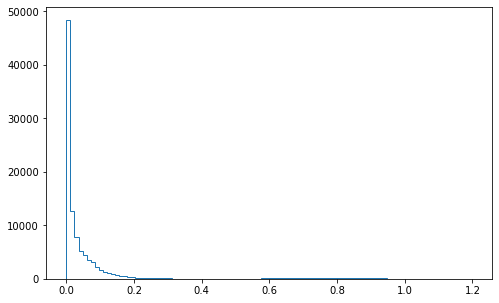

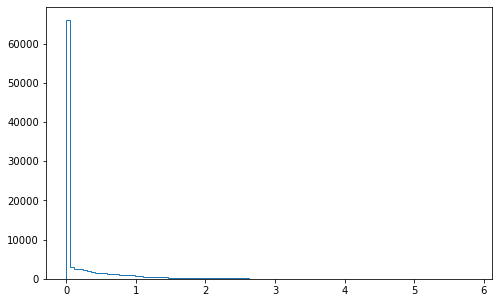

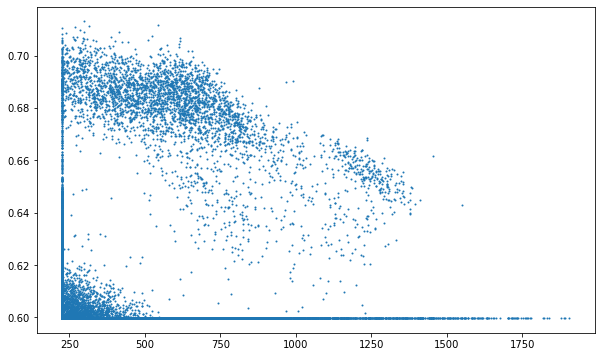

In [14]:
encoder     = tf.keras.Model(inputs, latent)
decoder     = tf.keras.Model(latent, outputs)

# Encode the input data to the latent space
latent_space = encoder.predict(X)

# Decode the latent space back to the original input space
reconstructed_input = decoder.predict(latent_space)

# visualize the latent space

for f in range(latent_space.shape[1]):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.hist(latent_space[:, f], bins=100, histtype="step", label=f"Feature {f}")
    plt.show()

X_reversed = scaler.inverse_transform(reconstructed_input)
# visualize the reconstructed input space
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X_reversed[:, 0], X_reversed[:, 1], s=1, label="Reconstructed input")
plt.show()

/Users/niklai/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/niklai/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


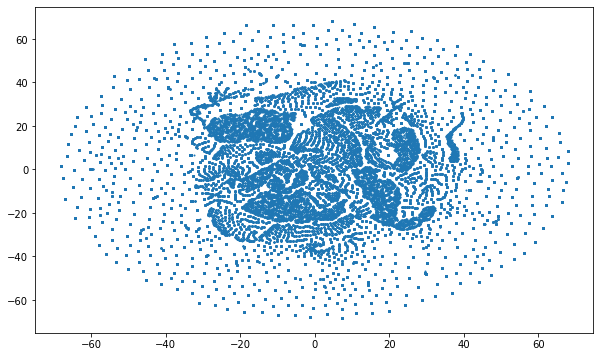

In [15]:
# TSNE
from sklearn.manifold import TSNE

# TSNE on the latent space to visualize the clusters in 2 dimensions
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

tsne_data = tsne.fit_transform(latent_space)

# convert to pandas dataframe
tsne_data = pd.DataFrame(tsne_data, columns=["x", "y"])

# visualize the clusters in 2D
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.scatter(tsne_data["x"], tsne_data["y"], s=1, label="TSNE")

plt.show()



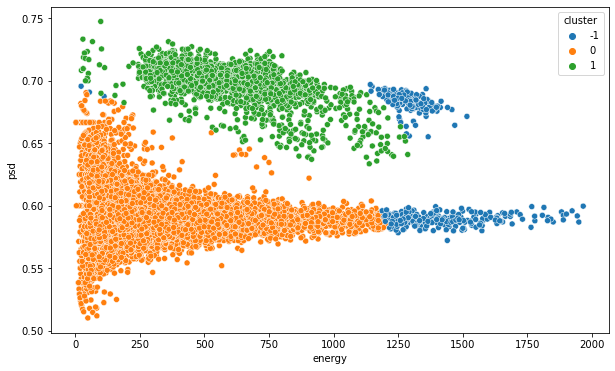

In [123]:
# use DBSCAN to find clusters

dbscan = DBSCAN(eps=1.4, min_samples=600)
cluster_labels = dbscan.fit_predict(latent_space)

df_subset['cluster'] = cluster_labels

# visualize the clusters
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.scatterplot(data=df_subset, x="energy", y="psd", hue="cluster", ax=ax, palette="tab10")

# ax.set_xscale("log")
plt.show()

In [143]:
df_subset['cluster'] = cluster_labels

In [146]:
# if the row with cluster label 1 has energy < 250 then its label is 0
df_subset.loc[(df_subset["cluster"] == 1) & (df_subset["energy"] < 200), "cluster"] = 0

# if the row with cluster label -1 has pdf greater than 0.65 then its label is 1
df_subset.loc[(df_subset["cluster"] == -1) & (df_subset["psd"] > 0.65) & (df_subset["energy"] > 220), "cluster"] = 1

# set all noise points to be label 0
df_subset.loc[df_subset["cluster"] == -1, "cluster"] = 0

In [161]:
# percentage of points in each cluster
print(df_subset["cluster"].value_counts(normalize=False))

0    48156
1     1844
Name: cluster, dtype: int64


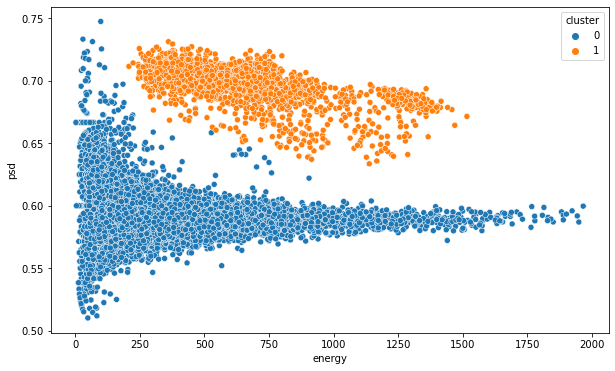

In [147]:
# visualize the clusters
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.scatterplot(data=df_subset, x="energy", y="psd", hue="cluster", ax=ax, palette="tab10")

# ax.set_xscale("log")
plt.show()

## Classifier

In [149]:
# build a classifier to distinguish between the two clusters and train it on the subset of the data

inputs = tf.keras.layers.Input(shape=(input_dim,), name="classifier_input")
dense = tf.keras.layers.Dense(32, activation="relu", name="classifier_layer_1")(inputs)
dense = tf.keras.layers.Dense(32, activation="relu", name="classifier_layer_2")(dense)
dense = tf.keras.layers.Dense(32, activation="relu", name="classifier_layer_3")(dense)
dense = tf.keras.layers.Dense(32, activation="relu", name="classifier_layer_4")(dense)
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="classifier_output")(dense)

model = tf.keras.Model(inputs, outputs, name="classifier")

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

model.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classifier_input (InputLaye  [(None, 2)]              0         
 r)                                                              
                                                                 
 classifier_layer_1 (Dense)  (None, 32)                96        
                                                                 
 classifier_layer_2 (Dense)  (None, 32)                1056      
                                                                 
 classifier_layer_3 (Dense)  (None, 32)                1056      
                                                                 
 classifier_layer_4 (Dense)  (None, 32)                1056      
                                                                 
 classifier_output (Dense)   (None, 1)                 33        
                                                        

In [150]:
# scale the data
X = scaler.fit_transform(df_subset[['energy', 'psd']])
Y = df_subset['cluster']

# train the model
model.fit(X, Y, epochs=10, batch_size=50, shuffle=True, validation_split=0.2)

Epoch 1/10


2022-12-19 15:40:35.819518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


795/800 [============================>.] - ETA: 0s - loss: 0.0374 - accuracy: 0.9936

2022-12-19 15:40:43.468493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


800/800 [==============================] - 9s 10ms/step - loss: 0.0371 - accuracy: 0.9937 - val_loss: 0.0010 - val_accuracy: 0.9997
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 9.6326e-04 - accuracy: 0.9997 - val_loss: 0.0013 - val_accuracy: 0.9993
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 6.7020e-04 - accuracy: 0.9998 - val_loss: 6.2291e-04 - val_accuracy: 0.9996
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 4.5755e-04 - val_accuracy: 0.9997
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 7.5232e-04 - accuracy: 0.9998 - val_loss: 0.0021 - val_accuracy: 0.9995
Epoch 6/10
800/800 [==============================] - 7s 8ms/step - loss: 8.5880e-04 - accuracy: 0.9997 - val_loss: 5.8150e-04 - val_accuracy: 0.9997
Epoch 7/10
800/800 [==============================] - 7s 8ms/step - loss: 4.3757e-04 - accuracy: 0.9998 - val_loss: 5.7722e-04 -

In [151]:
test_data = df_cluster.sample(100000)

pred = model.predict(scaler.transform(test_data[['energy', 'psd']]))

2022-12-19 15:42:21.853980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


ValueError: Image size of 615x188887 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x432 with 1 Axes>

In [153]:
# turn predictions into either 0 or 1 depending on the threshold value of 0.5
pred_int = np.where(pred > 0.5, 1, 0)

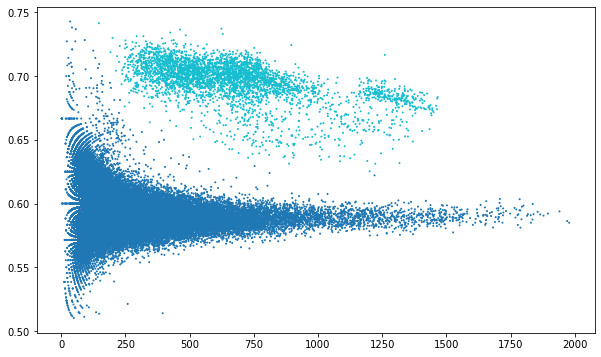

In [155]:
# visualize the predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.scatter(test_data['energy'], test_data['psd'], c=pred_int, s=1, cmap="tab10")

plt.show()

In [157]:
_, counts = np.unique(pred_int, return_counts=True)

In [158]:
# fraction of points that are predicted to be in cluster 1
print(counts[1] / counts.sum())

0.03661
